### Linear Model
Use the 37GHz V-pol band to predict ERA5 skin temperature (Both for Ascending and Descending passes)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize, CenteredNorm
from matplotlib.cm import ScalarMappable

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_squared_error

import cartopy.crs as ccrs


sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))
from src.processing import windsat_datacube, create_landmask

In [2]:
# Load
ws_path = "../../data/raw/daily_Windsat/"
wsds = windsat_datacube(ws_path)

igbp_path = "../../data/processed/IGBP_WindsatGrid.h5"
igbp_ds = xr.open_dataset(igbp_path)

# Use the IGBP classification and select all classes by 0 "water". It also removes big lakes.
wsds["IGBP"] = (("latitude_grid","longitude_grid"),igbp_ds.IGBP.values)
wsds = wsds.where(wsds.IGBP != 0)

# Map grid to lat-lon for plotting
wsds = wsds.swap_dims(
    {
        "latitude_grid": "lat",
        "longitude_grid": "lon",
    }
)
wsds = wsds.sortby(['lat', 'lon'])

# Select TbToA for  Ka V pol band, alongise the objective temperature
selection ={
    "polarization": 1, # 1 - Vertical
    "frequency_band": 1 # 1 - 37GHz
}
dvar_selection = ["tbtoa","surtep_ERA5"]
tbs = wsds.sel(**selection).reset_coords()[dvar_selection]

#Ascending vs descendig model
asc_tbs = tbs.sel(swath_sector = 0)
des_tbs = tbs.sel(swath_sector = 1)

datasets = [asc_tbs, des_tbs]


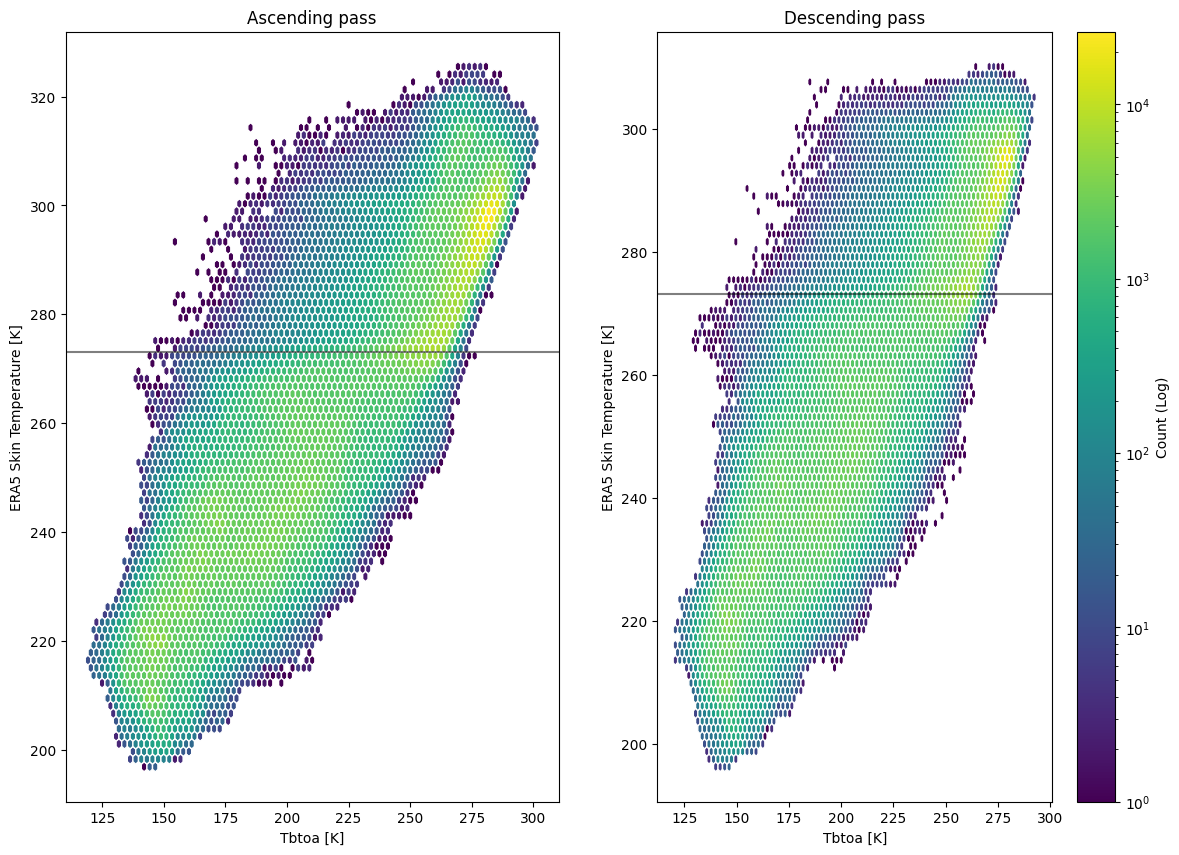

In [3]:
# All data plots:

fig, axs = plt.subplots(1,2, figsize = (14,10))

hexbinnorm = LogNorm(vmin= 1)
hexbin_kw = {
    "gridsize" : 80,
    "alpha" : 1,
    "edgecolors": "White",
    "norm" : hexbinnorm

}
regression_kw = {
    "color" : "Red",
    "alpha" : 0.7,
    "linestyle" : "--"
}
index2pass = {
    0 : "Ascending",
    1 : "Descending",
}

for i, ds in enumerate(datasets):
    ax = axs[i]
    df = ds.to_dataframe().reset_index(drop=True).dropna()
    
    ax.hexbin(x = df["tbtoa"], y = df["surtep_ERA5"], **hexbin_kw)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.axline((0,273.15), slope= 0, color = "Black", alpha = 0.5)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel("Tbtoa [K]")
    ax.set_ylabel("ERA5 Skin Temperature [K]")
    ax.set_title(f"{index2pass[i]} pass")

cbar = plt.colorbar(ScalarMappable(norm=hexbinnorm, cmap="viridis"), ax=ax, orientation='vertical', pad=0.05, label = "Count (Log)")

In [4]:
# Linear regression with each swath sector:
regs = []
dataframes = [ds.to_dataframe().reset_index(drop=True).dropna() for ds in datasets]
for df in dataframes:

    X=df["tbtoa"].values.reshape(-1, 1)
    y=df["surtep_ERA5"].values
    
    reg = LinearRegression()
    reg.fit(X, y)
    regs.append(reg)

    # Evaluate the model
    linear_score = reg.score(X, y)
    print("Model score:", linear_score)
    print(reg.intercept_, reg.coef_)


Model score: 0.8577991096086816
138.2872 [0.56365347]
Model score: 0.8350131840796927
142.8868 [0.5373599]


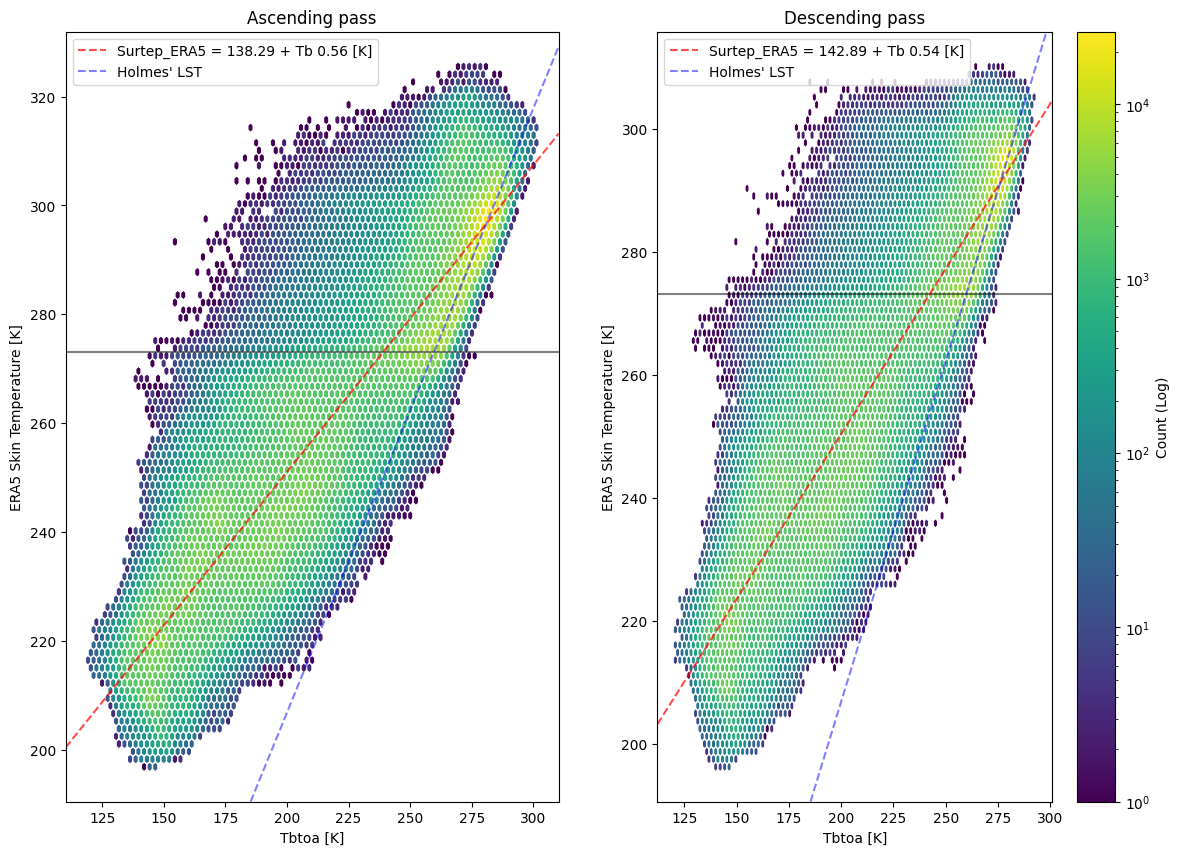

In [5]:
# Plots of corrected data:
fig, axs = plt.subplots(1,2, figsize = (14,10))

hexbinnorm = LogNorm(vmin= 1)
# hexbinnorm = Normalize()
hexbin_kw = {
    "gridsize" : 80,
    "alpha" : 1,
    "edgecolors": "White",
    "norm" : hexbinnorm

}
regression_kw = {
    "color" : "Red",
    "alpha" : 0.7,
    "linestyle" : "--"
}
index2pass = {
    0 : "Ascending",
    1 : "Descending",
}

for i, df in enumerate(dataframes):
    reg = regs[i]
    ax = axs[i]
    
    ax.hexbin(x = df["tbtoa"], y = df["surtep_ERA5"], **hexbin_kw)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.axline((0,273.15), slope= 0, color = "Black", alpha = 0.5)
    reg_label = f"Surtep_ERA5 = {reg.intercept_:.2f} + Tb {reg.coef_[0]:.2f} [K]"
    ax.axline((0,reg.intercept_), slope= reg.coef_[0], **regression_kw, label=reg_label)

    # Holmes' regression coefficients
    ax.axline((0,-15.2), slope = 1.11, color = "Blue", label ="Holmes' LST", alpha = 0.5, linestyle = "--")

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel("Tbtoa [K]")
    ax.set_ylabel("ERA5 Skin Temperature [K]")
    ax.set_title(f"{index2pass[i]} pass")

    ax.legend()


cbar = plt.colorbar(ScalarMappable(norm=hexbinnorm, cmap="viridis"), ax=ax, orientation='vertical', pad=0.05, label = "Count (Log)")




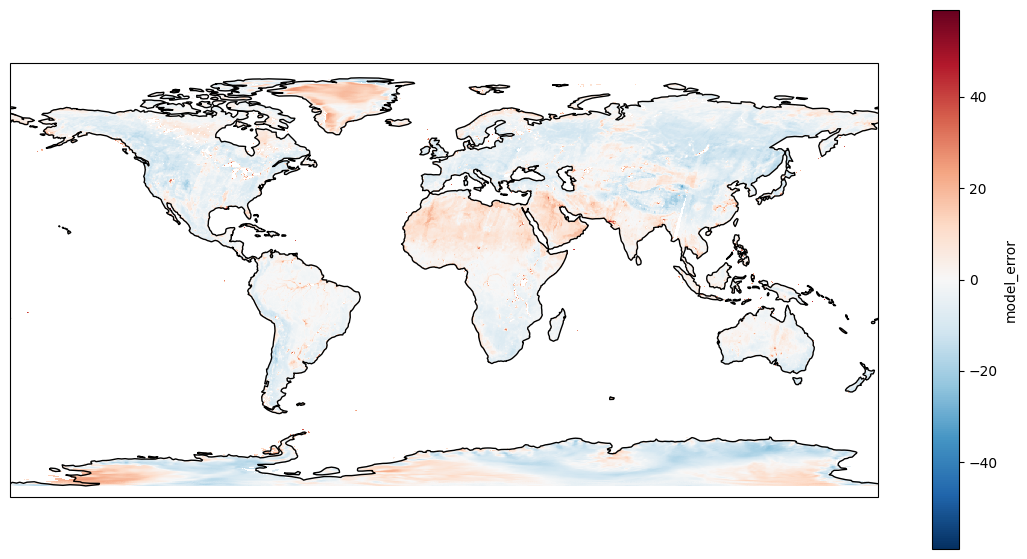

In [6]:
# Error map for model prediction
reg = regs[0]
ds["model_prediction"] = ds["tbtoa"] * reg.coef_ + reg.intercept_
ds["model_error"] = ds.surtep_ERA5 - ds.model_prediction

fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()

ds.model_error.mean(dim="day_number").plot()

In [7]:
# The Holmes' hipotheisys states that the valid range for TBs is 259.8 K
corrected_datasets = [ds.where(ds.tbtoa > (259.8)) for ds in datasets]
# Our model only works for surfaces avobe 2ºC
corrected_datasets = [ds.where(ds.surtep_ERA5 > (273.15 + 2)) for ds in corrected_datasets]

dataframes = [ds.to_dataframe().reset_index(drop=True).dropna() for ds in corrected_datasets]


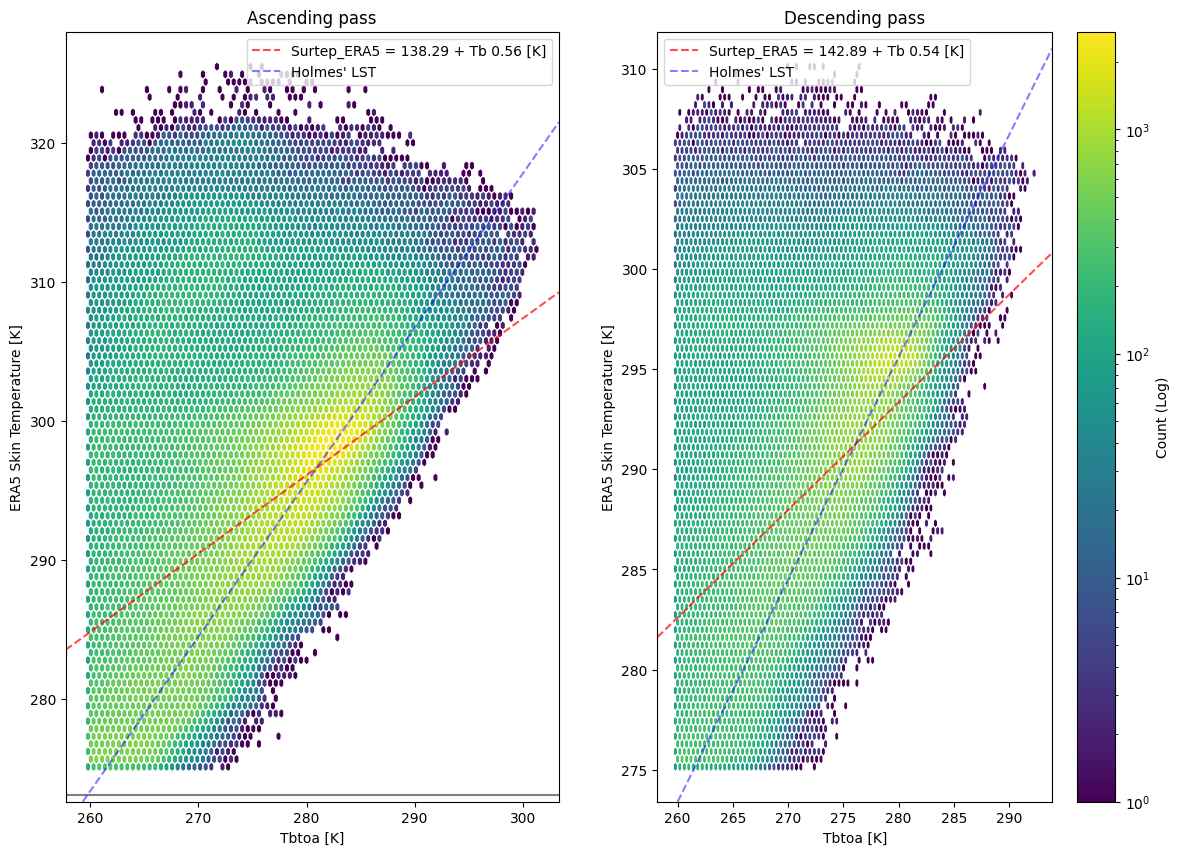

In [8]:
# Apply Holmes' original coefficients and see.

# Plots of corrected data:
fig, axs = plt.subplots(1,2, figsize = (14,10))

hexbinnorm = LogNorm(vmin= 1)
# hexbinnorm = Normalize()
hexbin_kw = {
    "gridsize" : 80,
    "alpha" : 1,
    "edgecolors": "White",
    "norm" : hexbinnorm

}
regression_kw = {
    "color" : "Red",
    "alpha" : 0.7,
    "linestyle" : "--"
}
index2pass = {
    0 : "Ascending",
    1 : "Descending",
}

for i, df in enumerate(dataframes):
    reg = regs[i]
    ax = axs[i]
    
    ax.hexbin(x = df["tbtoa"], y = df["surtep_ERA5"], **hexbin_kw)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.axline((0,273.15), slope= 0, color = "Black", alpha = 0.5)
    reg_label = f"Surtep_ERA5 = {reg.intercept_:.2f} + Tb {reg.coef_[0]:.2f} [K]"
    ax.axline((0,reg.intercept_), slope= reg.coef_[0], **regression_kw, label=reg_label)

    # Holmes' regression coefficients
    ax.axline((0,-15.2), slope = 1.11, color = "Blue", label ="Holmes' LST", alpha = 0.5, linestyle = "--")

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel("Tbtoa [K]")
    ax.set_ylabel("ERA5 Skin Temperature [K]")
    ax.set_title(f"{index2pass[i]} pass")

    ax.legend()


cbar = plt.colorbar(ScalarMappable(norm=hexbinnorm, cmap="viridis"), ax=ax, orientation='vertical', pad=0.05, label = "Count (Log)")


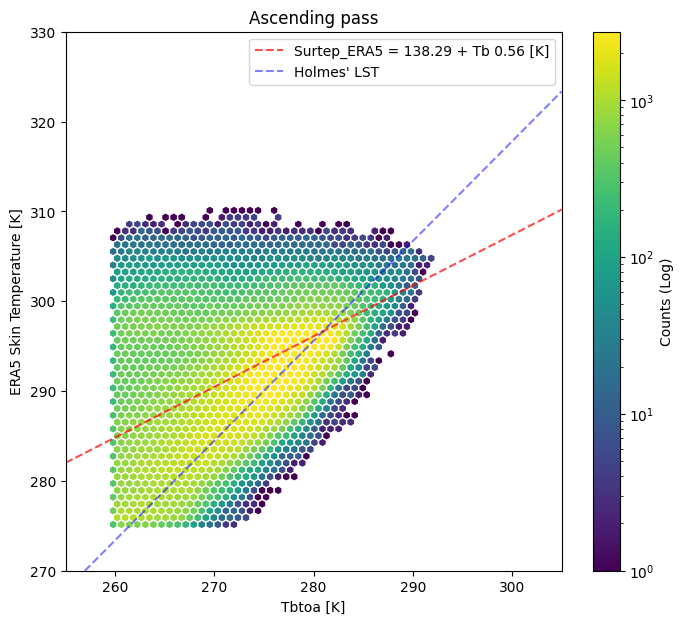

In [30]:
# Similar plot to compare with Holmes' regression.
fig, ax = plt.subplots(1,1, figsize = (8,7))

hexbin_kw = {
    "gridsize" : 40,
    "alpha" : 1,
    "edgecolors": "White",
    "norm" : hexbinnorm

}

reg = regs[0]
hexbin = ax.hexbin(x = df["tbtoa"], y = df["surtep_ERA5"], **hexbin_kw)

xlim = (255,305)
ylim = (270, 330)

reg_label = f"Surtep_ERA5 = {reg.intercept_:.2f} + Tb {reg.coef_[0]:.2f} [K]"
ax.axline((0,reg.intercept_), slope= reg.coef_[0], **regression_kw, label=reg_label)

# Holmes' regression coefficients
ax.axline((0,-15.2), slope = 1.11, color = "Blue", label ="Holmes' LST", alpha = 0.5, linestyle = "--")

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel("Tbtoa [K]")
ax.set_ylabel("ERA5 Skin Temperature [K]")
ax.set_title("Ascending pass")

ax.legend()
cbar = plt.colorbar(hexbin, ax=ax, orientation='vertical', pad=0.05, label = "Counts (Log)")



In [9]:
# Ascending vs descending model comparison 
swathid = 1

reg = regs[swathid]
ds = corrected_datasets[swathid]

ds["model_prediction"] = ds["tbtoa"] * reg.coef_ + reg.intercept_
ds["model_error"] = ds.surtep_ERA5 - ds.model_prediction

ds["Holmes_prediction"] = ds["tbtoa"] * 1.11 + (-15.2)
ds["Holmes_error"] = ds.surtep_ERA5 - ds.Holmes_prediction


Text(0.5, 1.0, 'Holmes_error')

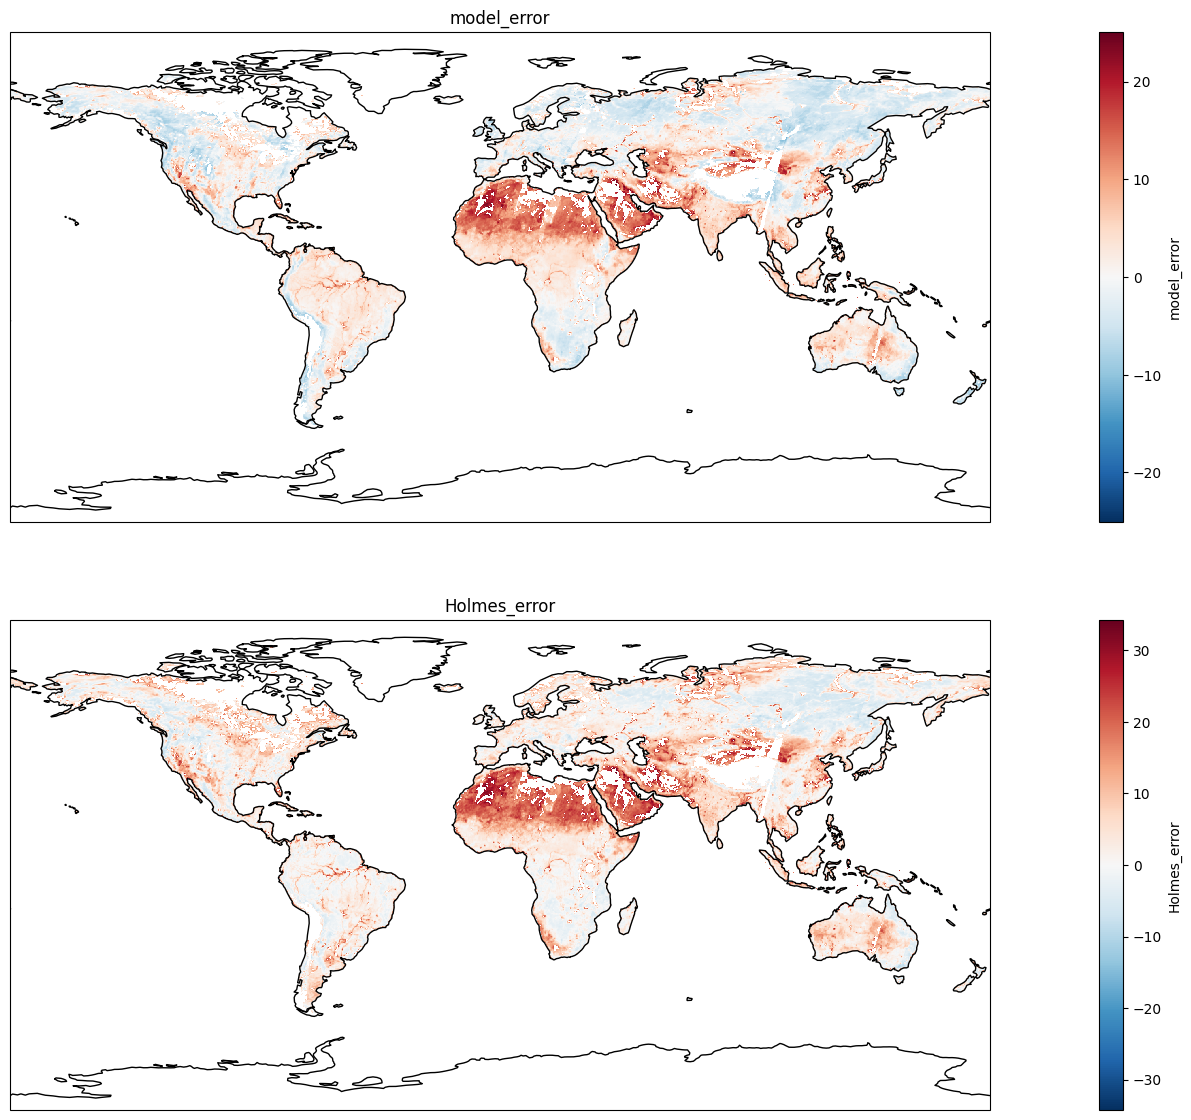

In [10]:
fig, axs = plt.subplots(2,1,figsize = (28,14), subplot_kw={"projection": ccrs.PlateCarree()})

ax = axs[0]
ax.coastlines()
ds.model_error.mean(dim="day_number").plot(ax=axs[0], add_colorbar=True)
ax.set_title("model_error")


ax = axs[1]
ax.coastlines()
ds.Holmes_error.mean(dim="day_number").plot(ax=axs[1], add_colorbar=True)
ax.set_title("Holmes_error")



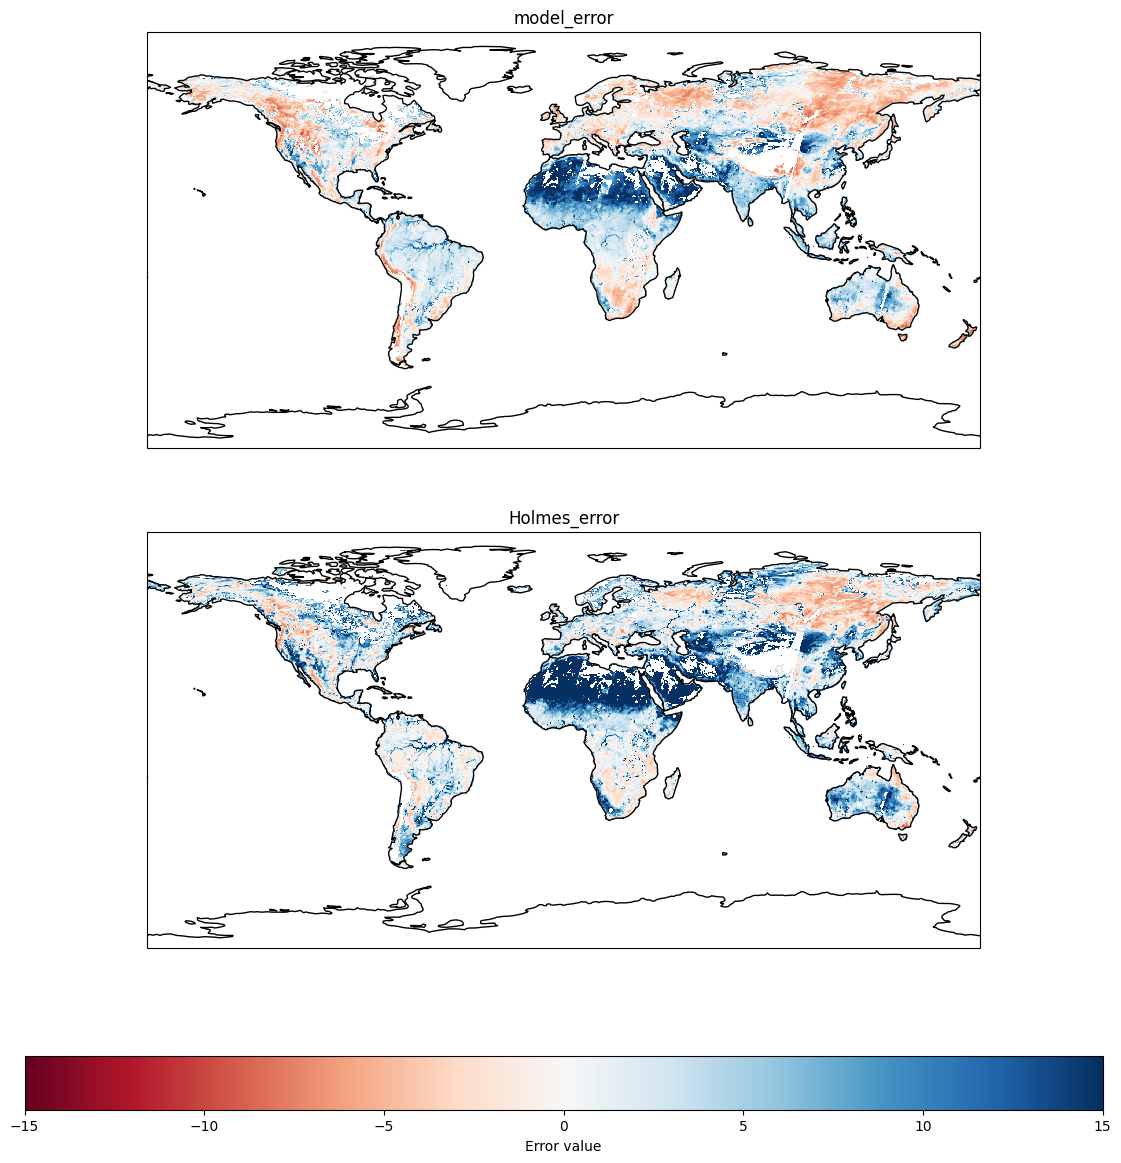

In [11]:
# Calcular los valores mínimos y máximos de los arrays usando .compute()
model_error_mean = ds.model_error.mean(dim="day_number").compute()
holmes_error_mean = ds.Holmes_error.mean(dim="day_number").compute()

# Obtener los valores absolutos máximos para centrar la escala en 0
vmax = max(abs(model_error_mean.min().item()), abs(model_error_mean.max().item()), 
           abs(holmes_error_mean.min().item()), abs(holmes_error_mean.max().item()))
vmax = 15
vmin = -vmax

# Crear la figura y los ejes
fig, axs = plt.subplots(2, 1, figsize=(28, 14), subplot_kw={"projection": ccrs.PlateCarree()})

# Graficar el primer mapa
ax = axs[0]
ax.coastlines()
im1 = model_error_mean.plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, cmap='RdBu')
ax.set_title("model_error")

# Graficar el segundo mapa
ax = axs[1]
ax.coastlines()
im2 = holmes_error_mean.plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, cmap='RdBu')
ax.set_title("Holmes_error")

# Añadir una sola colorbar para ambas gráficas
cbar = fig.colorbar(im1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Error value')

plt.show()


Regression         mse  Pearson R2      bias
0     LR - Ascending pass   61.897846    0.207903  1.639878
0   Holmes Ascending pass  100.309673   -0.283647  4.804882
0    LR - Descending pass   32.231392    0.229641  1.453364
0  Holmes Descending pass   56.289480   -0.345369  3.618122

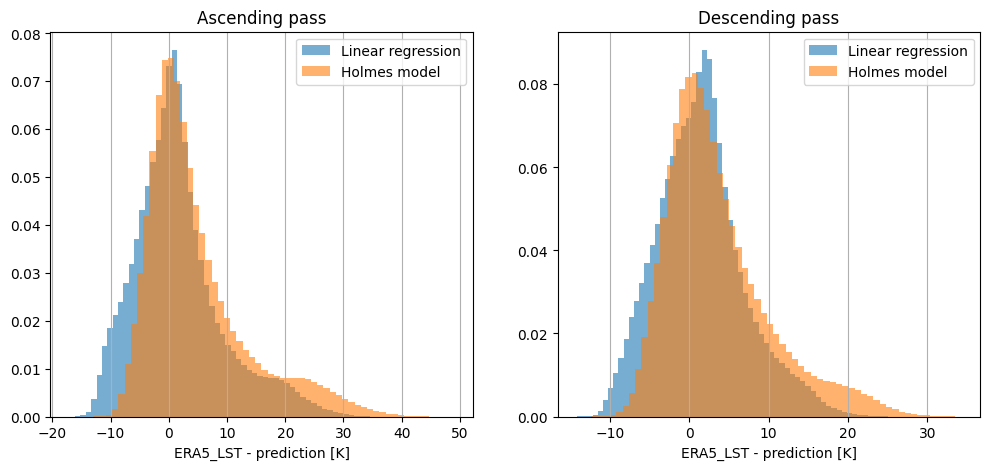

In [12]:
stats_df = pd.DataFrame()

# Define Holmes' regression
hreg = LinearRegression()
hreg.coef_ = np.array([1.11])
hreg.intercept_ = -15.2

# Also plot the error histogram
fig, axs = plt.subplots(1,2,figsize = (12,5))

histogram_kw = {
    "bins" : 60,
    "alpha" : 0.6,
    "density" : True,
}

for i,df in enumerate(dataframes):

    # Adjusted LR
    reg = regs[i]
    X=df["tbtoa"].values.reshape(-1, 1)
    y=df["surtep_ERA5"].values  

    model_mse = mean_squared_error(y,y_pred= reg.predict(X))
    model_linear_score = reg.score(X,y)

    df["model_prediction"] = df["tbtoa"] * reg.coef_[0] + reg.intercept_
    df["model_error"] = df["surtep_ERA5"] - df["model_prediction"]
    model_bias = df["model_error"].mean()

    model_df = pd.DataFrame({
        "Regression" : [f"LR - {index2pass[i]} pass"],
        "mse" : [model_mse],
        "Pearson R2" : [model_linear_score],
        "bias" : [model_bias],
    })

    # Holmes
    holmes_mse = mean_squared_error(y,y_pred=hreg.predict(X))
    holmes_linear_score = hreg.score(X,y)

    df["holmes_prediction"] = df["tbtoa"] * hreg.coef_ + hreg.intercept_
    df["holmes_error"] = df["surtep_ERA5"] - df["holmes_prediction"]
    holmes_bias = df["holmes_error"].mean()

    holmes_df = pd.DataFrame({
        "Regression" : [f"Holmes {index2pass[i]} pass"],
        "mse" : [holmes_mse],
        "Pearson R2" : [holmes_linear_score],
        "bias" : [holmes_bias],

    })

    # Record the stats
    stats_df = pd.concat([stats_df,model_df,holmes_df])

    # Error Histogram
    ax = axs[i]

    ax.hist(df["model_error"],**histogram_kw, label = "Linear regression")
    ax.hist(df["holmes_error"],**histogram_kw, label = "Holmes model")

    ax.set_title(f"{index2pass[i]} pass")
    ax.set_xlabel("ERA5_LST - prediction [K]")
    ax.legend()
    ax.grid(axis="x")


stats_df


In [13]:
print(stats_df.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
Regression & mse & Pearson R2 & bias \\
\midrule
LR - Ascending pass & 61.897846 & 0.207903 & 1.639878 \\
Holmes Ascending pass & 100.309673 & -0.283647 & 4.804882 \\
LR - Descending pass & 32.231392 & 0.229641 & 1.453364 \\
Holmes Descending pass & 56.289480 & -0.345369 & 3.618122 \\
\bottomrule
\end{tabular}

